In [62]:

import numpy as np
import matplotlib.pyplot as plt
import librosa
import sounddevice as sd
from scipy.signal import lfilter
from scipy.linalg import solve_toeplitz

# Import the filter_adaptively function
from lpctools import poly2rc, rc2lar, lar2rc, rc2poly
from filteradaptively import filter_adaptively
# Import LPC tools

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12



# =====================
# 2.0 Setup
# =====================

Loaded female8khz.wav with sampling rate: 8000 Hz
Signal duration: 2.25 seconds
Signal shape: (18000,)


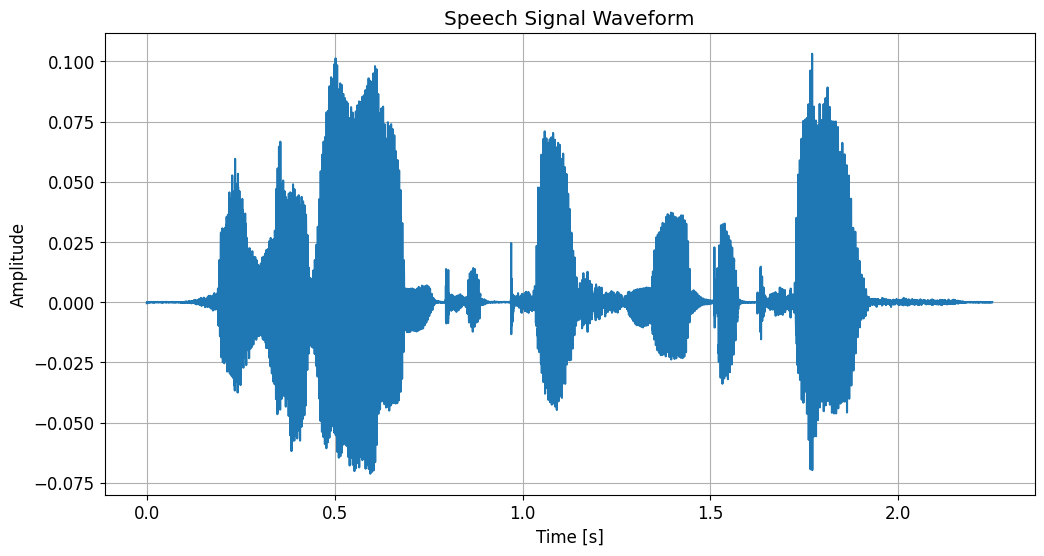

In [63]:
x, fs = librosa.load("female8khz.wav", sr=None)

# Print basic information
print(f"Loaded female8khz.wav with sampling rate: {fs} Hz")
print(f"Signal duration: {len(x)/fs:.2f} seconds")
print(f"Signal shape: {x.shape}")

# Create time vector for plotting
time = np.arange(len(x)) / fs

# Plot the waveform
plt.figure()
plt.plot(time, x)
plt.title('Speech Signal Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# =====================
# 2.1 Frame Segmentation
# =====================

In [64]:
# Define the windowing function from Exercise 1
def my_windowing(v_signal: np.ndarray, sampling_rate: int, frame_length_ms: int, frame_shift_ms: int):
    """
    Splits the signal into overlapping frames.

    Parameters:
        v_signal         : Input signal (1D numpy array)
        sampling_rate    : Sampling rate in Hz
        frame_length_ms  : Frame length in milliseconds
        frame_shift_ms   : Frame shift (hop size) in milliseconds

    Returns:
        m_frames         : 2D array with one frame per row
        v_time_frame     : Time instants (center) of each frame
    """
    frame_length = int((frame_length_ms / 1000) * sampling_rate)
    frame_shift = int((frame_shift_ms / 1000) * sampling_rate)
    
    # Calculate the number of frames that fit into the signal
    num_frames = 1 + (len(v_signal) - frame_length) // frame_shift

    # Initialize output arrays
    m_frames = np.zeros((num_frames, frame_length))
    v_time_frame = np.zeros(num_frames)

    for i in range(num_frames):
        start = i * frame_shift
        end = start + frame_length
        m_frames[i] = v_signal[start:end]
        v_time_frame[i] = (start + frame_length // 2) / sampling_rate

    return m_frames, v_time_frame

# Segment the signal with 32 ms frames and 8 ms shift
frame_length_ms = 32
frame_shift_ms = 8
m_frames, v_time_frame = my_windowing(x, fs, frame_length_ms, frame_shift_ms)

print(f"Number of frames: {len(m_frames)}")
print(f"Frame length: {m_frames.shape[1]} samples ({frame_length_ms} ms)")
print(f"Frame shift: {int((frame_shift_ms / 1000) * fs)} samples ({frame_shift_ms} ms)")

Number of frames: 278
Frame length: 256 samples (32 ms)
Frame shift: 64 samples (8 ms)


In [65]:
# =====================
# 2.2 Signal power
# =====================

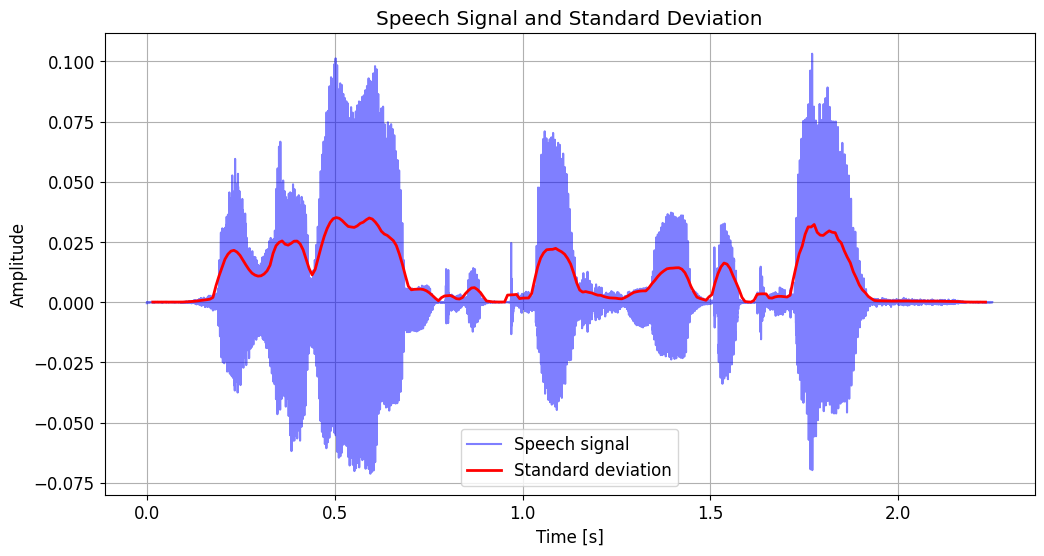

In [66]:
def compute_power(segment):
    """
    Compute the signal power of a segment.
    
    Parameters:
        segment: Input signal segment
        
    Returns:
        power: Signal power
    """
    return np.mean(segment**2)

# Compute power for each frame
v_power = np.array([compute_power(frame) for frame in m_frames])

# Compute standard deviation (sqrt of power)
v_std = np.sqrt(v_power)

# Plot the waveform and standard deviation
plt.figure()
plt.plot(time, x, 'b', alpha=0.5, label='Speech signal')
plt.plot(v_time_frame, v_std, 'r', linewidth=2, label='Standard deviation')
plt.title('Speech Signal and Standard Deviation')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# =====================
# 2.3 Voiced / unvoiced decision
# =====================


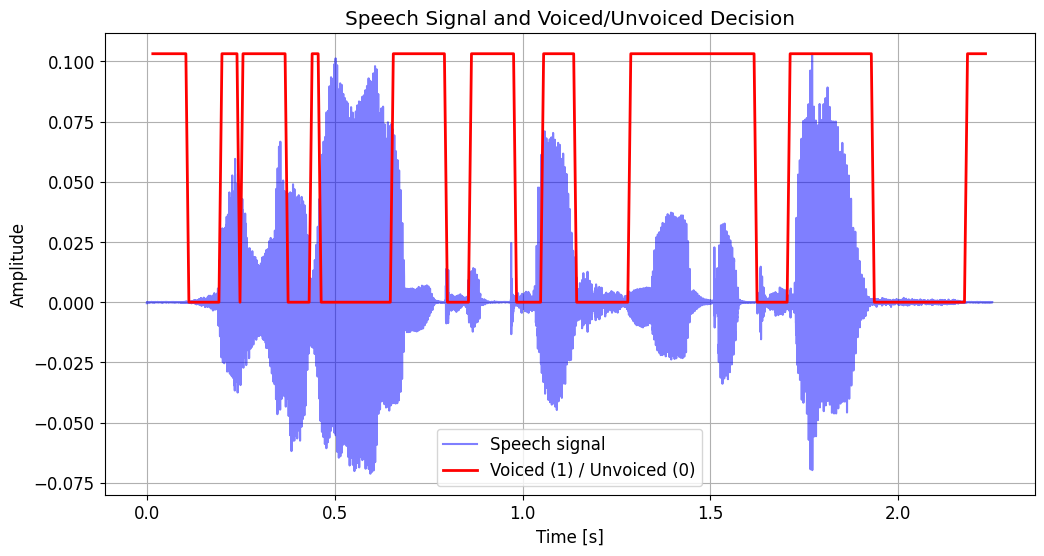

In [67]:
def is_voiced(segment, threshold=0.2):
    """
    Determine if a segment is voiced or unvoiced based on zero-crossing rate.
    
    Parameters:
        segment: Input signal segment
        threshold: Threshold for zero-crossing rate decision
        
    Returns:
        1 if voiced, 0 if unvoiced
    """
    # Count zero crossings
    # A zero crossing occurs when the sign changes between consecutive samples
    # We can detect this by multiplying adjacent samples and checking if the result is negative
    zero_crossings = np.sum(segment[:-1] * segment[1:] < 0)
    
    # Normalize by segment length
    zero_crossing_rate = zero_crossings / (len(segment) - 1)
    
    # Apply threshold
    return 1 if zero_crossing_rate < threshold else 0

# Compute voiced/unvoiced decision for each frame
v_voiced = np.apply_along_axis(is_voiced, 1, m_frames)

# Plot the waveform and voiced/unvoiced decision
plt.figure()
plt.plot(time, x, 'b', alpha=0.5, label='Speech signal')
plt.plot(v_time_frame, v_voiced * max(abs(x)), 'r', linewidth=2, label='Voiced (1) / Unvoiced (0)')
plt.title('Speech Signal and Voiced/Unvoiced Decision')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


# =====================
# 2.4 Fundamental frequency estimation
# =====================

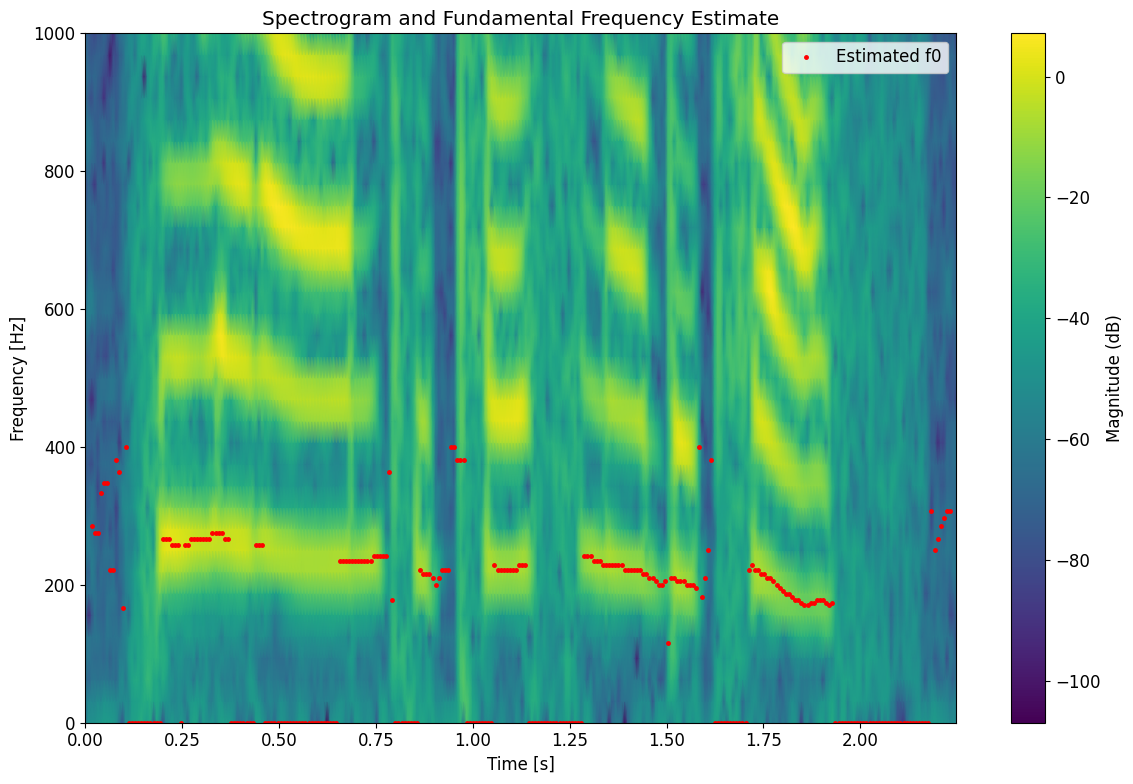

In [68]:
def compute_acf_matrix(m_frames):
    """
    Compute the autocorrelation function (ACF) for each frame.
    Returns only the positive-lag part of the ACF (lags >= 0).

    Parameters:
        m_frames : 2D array of frames (each row is a frame)

    Returns:
        acf_matrix : 2D array with ACFs (lags >= 0)
    """
    num_frames, frame_len = m_frames.shape
    acf_matrix = np.zeros((num_frames, frame_len))

    for i in range(num_frames):
        frame = m_frames[i]
        # Full ACF via convolution of frame with time-reversed version
        acf_full = np.convolve(frame, frame[::-1], mode='full')
        # Keep only lags >= 0 (centered at frame_len - 1)
        acf_matrix[i] = acf_full[frame_len - 1:]

    return acf_matrix

def estimate_f0(m_frames, fs, fmin=80, fmax=400):
    """
    Estimate the fundamental frequency from frames using autocorrelation.
    
    Parameters:
        m_frames: Matrix of signal frames
        fs: Sampling frequency in Hz
        fmin: Minimum allowed frequency in Hz
        fmax: Maximum allowed frequency in Hz
        
    Returns:
        v_f0_estimates: Vector of fundamental frequency estimates in Hz
    """
    # Compute ACF for all frames
    acf_matrix = compute_acf_matrix(m_frames)
    
    num_frames, frame_len = acf_matrix.shape
    v_f0_estimates = np.zeros(num_frames)
    
    # Convert frequency range to lag range
    min_lag = int(fs / fmax)
    max_lag = int(fs / fmin)
    
    for i in range(num_frames):
        # Only estimate f0 for voiced frames
        if v_voiced[i] == 1:
            acf = acf_matrix[i]
            # Search for peak in valid lag range
            search_region = acf[min_lag:max_lag]
            if len(search_region) > 0:
                peak_index = np.argmax(search_region) + min_lag
                v_f0_estimates[i] = fs / peak_index
        else:
            v_f0_estimates[i] = 0  # Set f0 to 0 for unvoiced frames
    
    return v_f0_estimates

# Estimate fundamental frequency
v_f0 = estimate_f0(m_frames, fs)

# Compute spectrogram for visualization
def compute_stft(signal, fs, frame_length_ms=32, frame_shift_ms=8, window='hann'):
    """
    Compute the Short-Time Fourier Transform (STFT) of a signal.
    
    Parameters:
        signal: Input signal
        fs: Sampling frequency in Hz
        frame_length_ms: Frame length in milliseconds
        frame_shift_ms: Frame shift in milliseconds
        window: Window type
        
    Returns:
        stft_magnitude: Magnitude of STFT
        time_vec: Time vector
        freq_vec: Frequency vector
    """
    n_fft = int((frame_length_ms / 1000) * fs)
    hop_length = int((frame_shift_ms / 1000) * fs)
    
    # Compute STFT
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, window=window)
    stft_magnitude = np.abs(stft)
    
    # Create time and frequency vectors
    time_vec = librosa.times_like(stft_magnitude, sr=fs, hop_length=hop_length)
    freq_vec = librosa.fft_frequencies(sr=fs, n_fft=n_fft)
    
    return stft_magnitude, time_vec, freq_vec

# Compute spectrogram
stft_magnitude, stft_time, stft_freq = compute_stft(x, fs)

# Plot fundamental frequency estimate with spectrogram
plt.figure(figsize=(12, 8))

# Plot spectrogram
plt.pcolormesh(stft_time, stft_freq, 20 * np.log10(stft_magnitude + 1e-10), shading='gouraud', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')

# Plot fundamental frequency
plt.plot(v_time_frame, v_f0, 'r.', markersize=5, label='Estimated f0')

plt.title('Spectrogram and Fundamental Frequency Estimate')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 1000)  # Limit y-axis to focus on speech frequencies
plt.legend()
plt.tight_layout()
plt.show()


# =====================
# 2.5 Linear prediction coefficients / linear predictive coding
# =====================

In [69]:
def compute_lpc(m_frames, M):
    """
    Compute Linear Prediction coefficients using autocorrelation method.
    
    Parameters:
        m_frames: Matrix of signal frames
        M: Order of the LP filter
        
    Returns:
        m_lpc: Matrix of LP coefficients for each frame
    """
    num_frames = m_frames.shape[0]
    m_lpc = np.zeros((num_frames, M))
    
    for i in range(num_frames):
        frame = m_frames[i]
        
        # Compute autocorrelation
        r = np.correlate(frame, frame, mode='full')
        # Extract the positive lags (center to right half)
        r = r[len(frame)-1:len(frame)+M+1]
        
        # Solve the Toeplitz system
        a = solve_toeplitz(r[:M], r[1:M+1])
        
        # Store the LP coefficients
        m_lpc[i] = a
    
    return m_lpc

# Choose LP model order
M = 10

# Compute LPCs for all frames
m_lpc = compute_lpc(m_frames, M)
lpcs = np.concatenate([np.ones((m_lpc.shape[0],1)), -m_lpc], axis=1)

print(f"LPC matrix shape: {m_lpc.shape}")
print(f"First frame LPCs: {m_lpc[0]}")

LPC matrix shape: (278, 10)
First frame LPCs: [0.22536623 0.17135223 0.04327589 0.04334965 0.10083971 0.00464616
 0.00262016 0.04801996 0.13100982 0.01036855]


# =====================
# 3 LPC-vocoder: synthesis
# =====================


# =====================
# 3.1 LPC-vocoder: synthesis
# =====================

In [70]:
def generate_excitation(num_samples, v_voiced, v_f0, fs, frame_length_ms, frame_shift_ms):
    """
    Generate excitation signal based on voiced/unvoiced decision and f0.
    Pulses for voiced frames, Gaussian noise for unvoiced.
    """
    excitation = np.zeros(num_samples)
    frame_length = int((frame_length_ms / 1000) * fs)
    frame_shift  = int((frame_shift_ms  / 1000) * fs)
    for i in range(len(v_voiced)):
        start = i * frame_shift
        end   = min(start + frame_length, num_samples)
        if v_voiced[i] == 1:  # Voiced
            period = int(fs / v_f0[i]) if v_f0[i] > 0 else 0
            if period > 0:
                for j in range(start, end):
                    if (j % period) == 0:
                        excitation[j] = 1.0
        else:  # Unvoiced
            excitation[start:end] = np.random.randn(end - start)
    return excitation



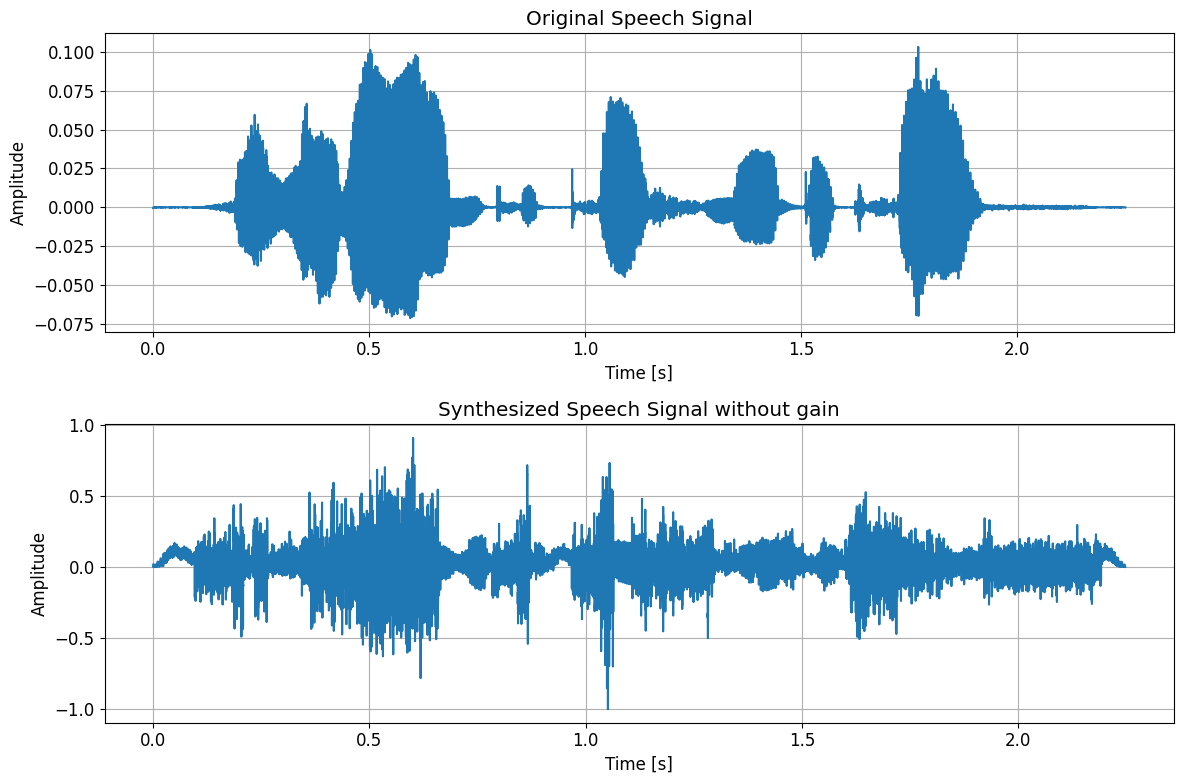

Playing original signal...
Playing synthesized signal...


In [71]:
def synthesize_speech(v_voiced: np.ndarray, v_f0: np.ndarray,lpcs: np.ndarray,fs: int, frame_length_ms: int,frame_shift_ms: int):
    # Convert ms to samples
    L = int(frame_length_ms / 1000 * fs)
    S = int(frame_shift_ms  / 1000 * fs)
    Nf = len(v_voiced)
    # Generate excitation
    exc = generate_excitation(Nf * S + L - S, v_voiced, v_f0, fs,
                              frame_length_ms, frame_shift_ms)
    N = len(exc)
    syn = np.zeros(N)
    filter_state = None

    # Overlap-add per frame with adaptive filter only
    for i in range(Nf):
        st = i * S
        en = min(st + L, N)
        segment = exc[st:en]
        # Build LPC polynomial
        a = lpcs[i]
        # Apply adaptive filter without gain
        out_seg, filter_state = filter_adaptively(np.array([1.0]), a, segment, filter_state)
        syn[st:en] += out_seg
    return syn

synthesized = synthesize_speech(v_voiced, v_f0, lpcs,fs, frame_length_ms, frame_shift_ms)

# Normalize to prevent clipping
synthesized = synthesized / np.max(np.abs(synthesized))

# Plot original and synthesized signals
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(time, x)
plt.title('Original Speech Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
synth_time = np.arange(len(synthesized)) / fs
plt.plot(synth_time, synthesized)
plt.title('Synthesized Speech Signal without gain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

# Play original and synthesized signals
print("Playing original signal...")
sd.play(x, fs)
sd.wait()

print("Playing synthesized signal...")
sd.play(synthesized, fs)
sd.wait()




# =====================
# 3.3 Amplitude modulation
# =====================

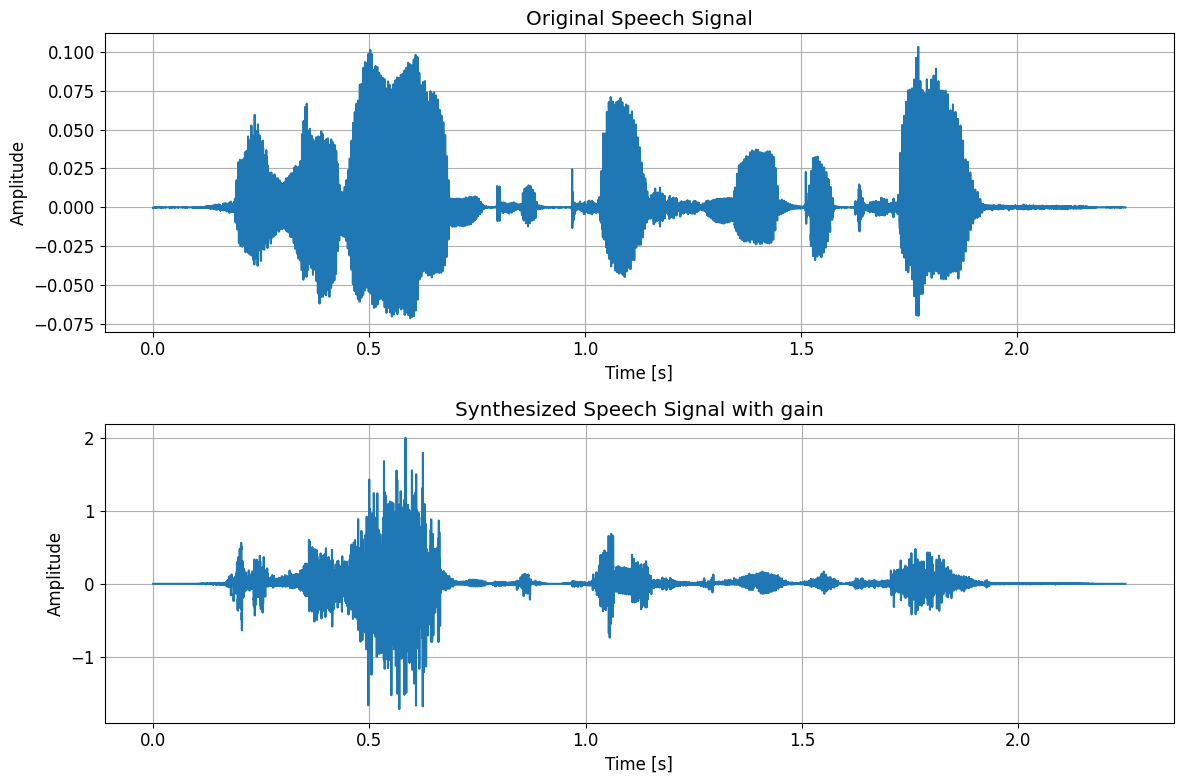

Playing original signal...
Playing synthesized signal...


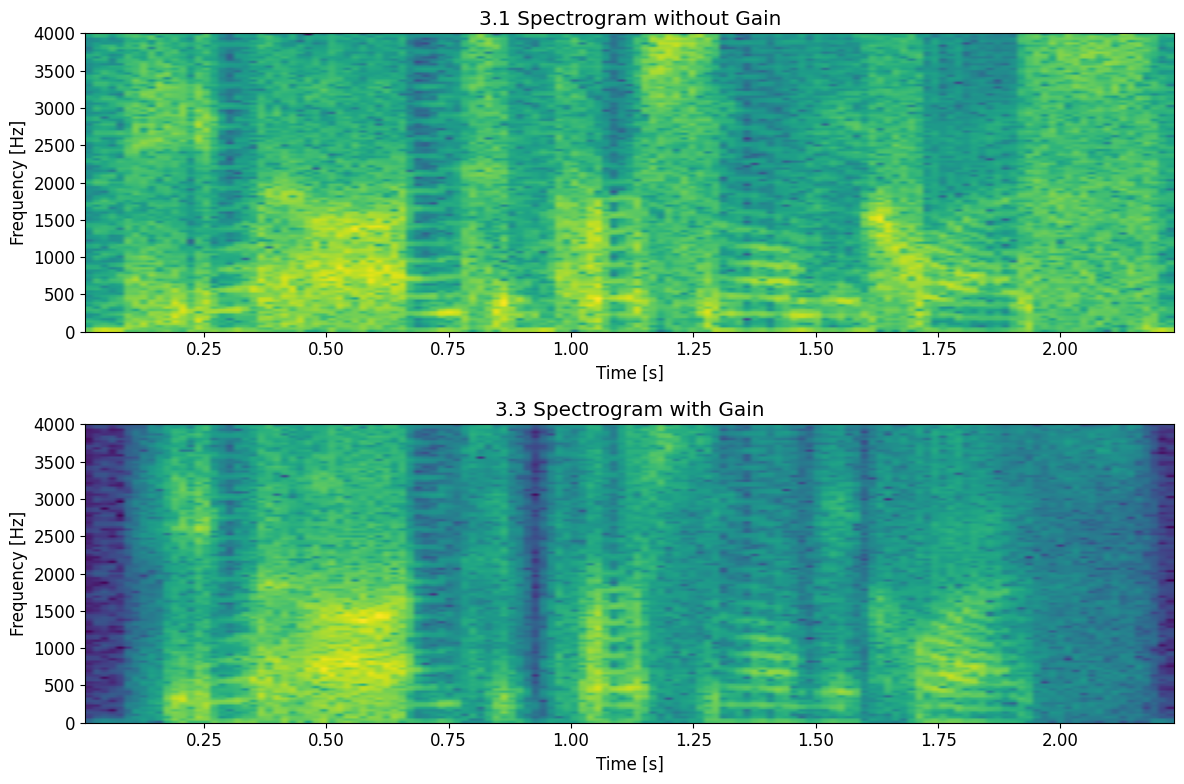

In [72]:
def synthesize_speech_gain(v_voiced: np.ndarray, v_f0: np.ndarray,lpcs: np.ndarray, v_power: np.ndarray,fs: int, frame_length_ms: int,frame_shift_ms: int):
    # Convert ms to samples
    L = int(frame_length_ms / 1000 * fs)
    S = int(frame_shift_ms  / 1000 * fs)
    Nf = len(v_voiced)
    # Generate excitation
    exc = generate_excitation(Nf * S + L - S, v_voiced, v_f0, fs,frame_length_ms, frame_shift_ms)
    N = len(exc)
    syn = np.zeros(N)
    filter_state = None

    # Overlap-add per frame with adaptive filter and gain
    for i in range(Nf):
        st = i * S
        en = min(st + L, N)
        segment = exc[st:en]
        # apply gain from power envelope
        gain = np.sqrt(v_power[i])
        segment = segment * gain
        # LPC filter polynomial
        a = lpcs[i]
        # Adaptive filtering carries filter state
        out_seg, filter_state = filter_adaptively(np.array([1.0]), a, segment, filter_state)
        syn[st:en] += out_seg
    return syn

synthesized1 = synthesize_speech_gain(v_voiced, v_f0, lpcs, v_power, fs, frame_length_ms, frame_shift_ms)

# Normalize to prevent clipping
synthesized2 = synthesized1 / np.max(np.abs(synthesized))

# Plot original and synthesized signals
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(time, x)
plt.title('Original Speech Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
synth_time = np.arange(len(synthesized2)) / fs
plt.plot(synth_time, synthesized2)
plt.title('Synthesized Speech Signal with gain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

# Play original and synthesized signals
print("Playing original signal...")
sd.play(x, fs)
sd.wait()

print("Playing synthesized signal...")
sd.play(synthesized2, fs)
sd.wait()

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.specgram(synthesized, NFFT=256, Fs=fs, noverlap=128)
plt.title('3.1 Spectrogram without Gain')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

plt.subplot(2, 1, 2)
plt.specgram(synthesized2, NFFT=256, Fs=fs, noverlap=128)
plt.title('3.3 Spectrogram with Gain')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

plt.tight_layout()
plt.show()

# =====================
# 3.3 Amplitude modulation and 3.4 Variable f0
# =====================

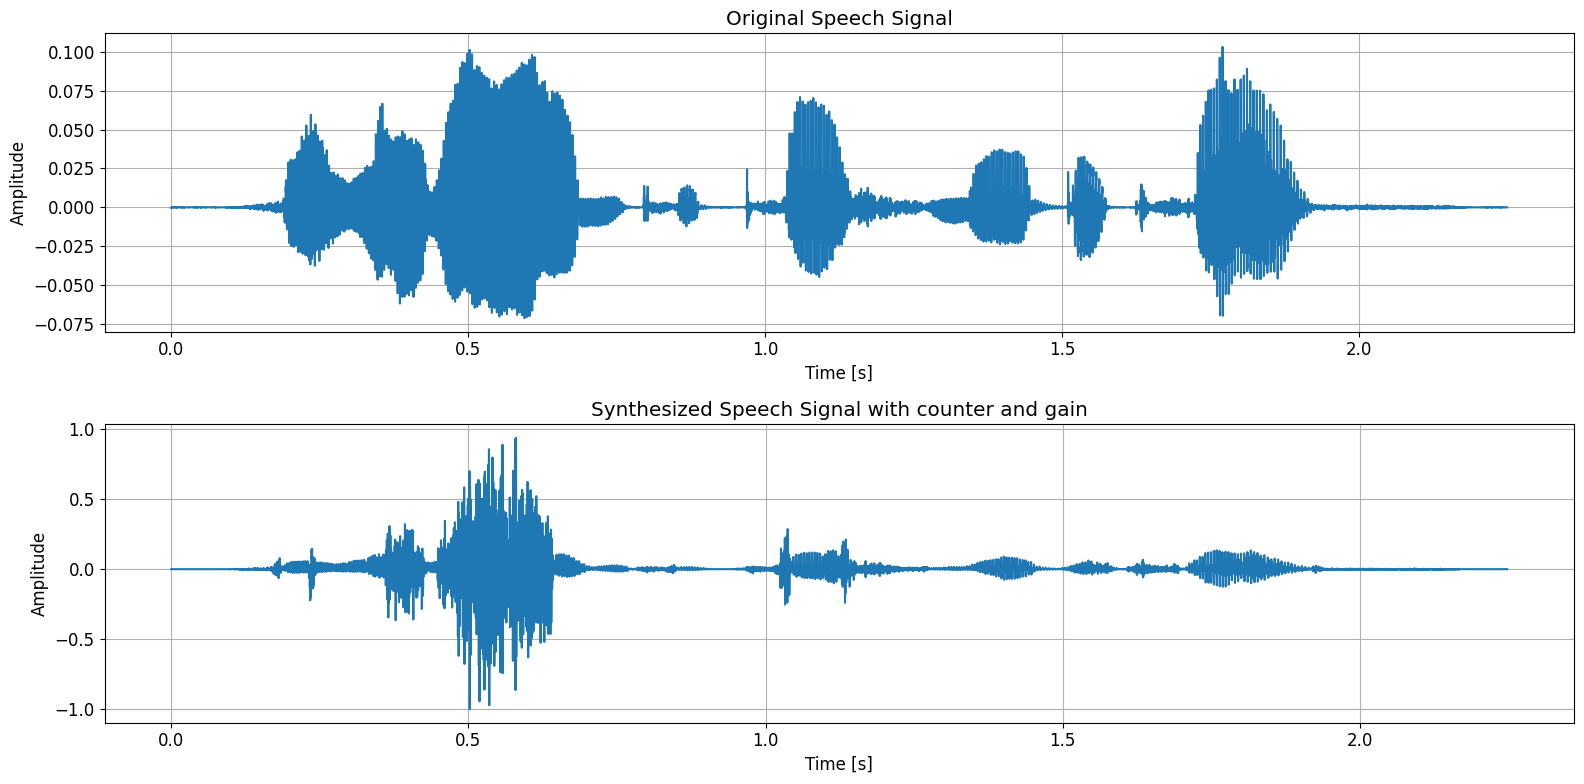

Playing original signal...
Playing synthesized signal...


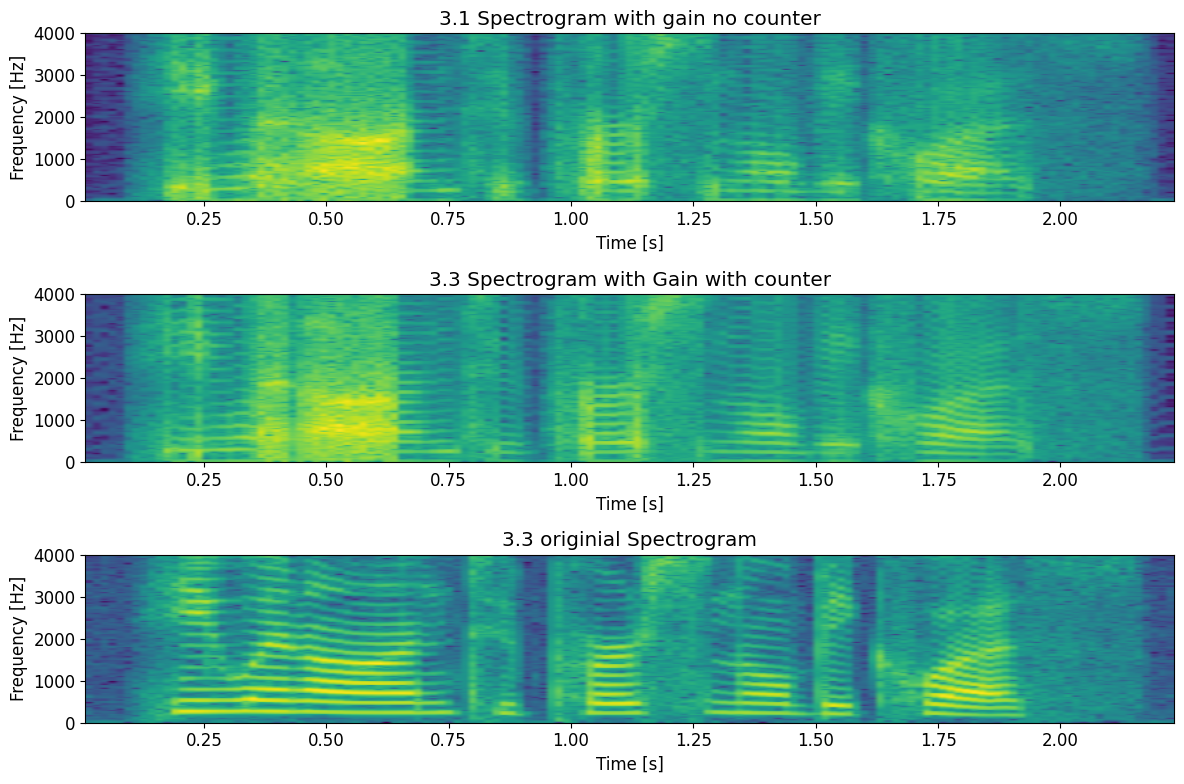

In [73]:
import numpy as np

def generate_excitation_variable_f0(num_samples, v_voiced, v_f0, fs, frame_shift_ms):
    """
    Generate excitation signal:
      - In voiced segments: pulse train with variable f0, phase‑continuous across frames
      - In unvoiced segments: white Gaussian noise
    """
    excitation = np.zeros(num_samples)
    S = int(frame_shift_ms * fs / 1000)
    counter = 0
    Nf = len(v_voiced)

    for n in range(num_samples):
        # frame_idx klampen, damit 0 <= frame_idx < Nf
        frame_idx = n // S
        if frame_idx >= Nf:
            frame_idx = Nf - 1

        if v_voiced[frame_idx]:
            if v_f0[frame_idx] > 0:
                period = int(fs / v_f0[frame_idx])
                if counter == 0:
                    excitation[n] = 1.0
                counter += 1
                if counter >= period:
                    counter = 0
        else:
            excitation[n] = np.random.randn()
            # counter unverändert, um Phase zu erhalten

    return excitation


def synthesize_speech_variable_f0(v_voiced, v_f0, lpcs, v_power, fs, frame_length_ms, frame_shift_ms):
    """
    Synthetisiert Sprache durch:
      1) Erzeugen der Excitation
      2) Frame‑weises Gain
      3) LPC‑Filter mit Overlap‑Add
      4) Normalisierung
    """
    L = int(frame_length_ms * fs / 1000)
    S = int(frame_shift_ms  * fs / 1000)
    Nf = len(v_voiced)
    num_samples = Nf * S + L - S

    # 1) Excitation erzeugen
    exc = generate_excitation_variable_f0(num_samples, v_voiced, v_f0, fs, frame_shift_ms)

    # 2–3) Synthetisieren per Frame
    syn = np.zeros(num_samples)
    filter_state = None
    for i in range(Nf):
        start = i * S
        end   = start + L
        segment = exc[start:end]

        gain = np.sqrt(v_power[i])
        segment = segment * gain

        out_seg, filter_state = filter_adaptively(np.array([1.0]), lpcs[i], segment, filter_state)
        syn[start:end] += out_seg

    # 4) Normalisieren (kleines epsilon um Div/0 zu vermeiden)
    syn = syn / (np.max(np.abs(syn)) + 1e-12)
    return syn


synthesized3 = synthesize_speech_variable_f0(v_voiced, v_f0, lpcs, v_power, fs, frame_length_ms, frame_shift_ms)

synthesized4 = synthesized3 / np.max(np.abs(synthesized3))

# Plot original and synthesized signals
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(time, x)
plt.title('Original Speech Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
synth_time = np.arange(len(synthesized4)) / fs
plt.plot(synth_time, synthesized4)
plt.title('Synthesized Speech Signal with counter and gain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

# Play original and synthesized signals
print("Playing original signal...")
sd.play(x, fs)
sd.wait()

print("Playing synthesized signal...")
sd.play(synthesized4, fs)
sd.wait()

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.specgram(synthesized2, NFFT=256, Fs=fs, noverlap=128)
plt.title('3.1 Spectrogram with gain no counter')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

plt.subplot(3, 1, 2)
plt.specgram(synthesized4, NFFT=256, Fs=fs, noverlap=128)
plt.title('3.3 Spectrogram with Gain with counter')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.subplot(3, 1, 3)
plt.specgram(x, NFFT=256, Fs=fs, noverlap=128)
plt.title('3.3 originial Spectrogram')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')


plt.tight_layout()
plt.show()



# =====================
# 3.5 No LPC
# =====================

#How does leaving out the LPC step influence the spectrum?
Omitting the LPC filter removes the vocal‑tract resonances, so the spectrum becomes much “flatter” and more noise‑like—there are no sharp formant bands at the characteristic frequencies.

Spectrogram comparison & explanation

With LPC (middle plot in 3.3): you see clear bands around ~500 Hz, 1500 Hz, 2500 Hz, etc., corresponding to vowel formants.

Without LPC (bottom plot in 3.5): those bands vanish, leaving a diffuse energy distribution across frequencies.
This confirms that LPC modeling is exactly what sculpts those formant peaks.

Can you understand what is said?
Barely, if at all. Without the formant structure, vowels and consonants merge into a bleary, noise‑like signal that lacks distinct phonetic cues.

How important is the vocal tract for intelligibility?
Extremely important. The vocal‑tract filter (modeled by LPC) is essential to create the resonant formants that make speech phonemes identifiable.

Which parameters are most critical?

Intelligibility: LPC coefficients (spectral envelope/formants) are by far the most crucial.

Naturalness/Quality: f₀ variation (pitch modulation) and gain envelope add prosodic nuance and realism.

Speaker recognition: primarily the spectral envelope (vocal‑tract shape), with secondary cues from individual pitch patterns and fine-timing details.

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Line Sharpness vs. Bandwidth

Synthesized: Perfectly timed impulses + sharp LPC poles → very thin, crisp harmonic lines.

Original: Small cycle‑to‑cycle variations (jitter), aspiration noise, and damping in the vocal tract → harmonics smear out into broader bands.

Formant Bandwidth

Synthesized: Narrow poles yield narrow formant peaks.

Original: Physical resonances have finite bandwidth (hundreds of Hz) → wide, soft formant bands.

# =====================
# 4. Quantization
# =====================

## 4.1 Implementation of a Uniform Scalar Quantizer

**Tasks:**
1. Implement `quantize_encoder(x, num_bits, x_range, x_center)` to map a real‑valued vector **x** onto quantization indices.
2. Implement `quantize_decoder(quant_idxs, num_bits, x_range, x_center)` to reconstruct quantized values.
3. Test on a ramp `x ∈ [−5, 5]`, with `x_range=6`, `x_center=0`, `num_bits=2`. Plot original vs quantized.
4. Discuss:
   - How many quantization levels for n bits?
   - How to choose `x_center`?
   - Effect of changing `x_center`.

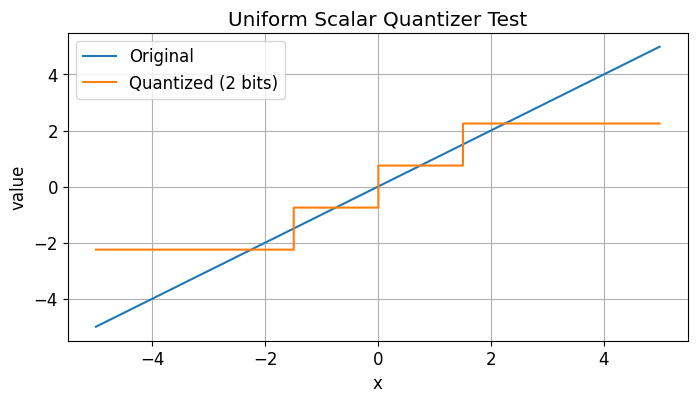

In [82]:
import numpy as np
import matplotlib.pyplot as plt

def quantize_encoder(x: np.ndarray, num_bits: int, x_range: float, x_center: float) -> np.ndarray:
    """Improved version with better edge case handling"""
    L = 2**num_bits
    delta = x_range / L
    x_min = x_center - x_range/2
    
    # Normalize to [0, L-1] range
    indices = np.floor((x - x_min) / delta).astype(int)
    
    # Proper clipping with warning for out-of-range values
    clipped_indices = np.clip(indices, 0, L-1)
    
    return clipped_indices

def quantize_decoder(quant_idxs: np.ndarray, num_bits: int, x_range: float, x_center: float) -> np.ndarray:
    L = 2**num_bits
    Δ = x_range / L
    return (x_center - x_range/2) + (quant_idxs + 0.5)*Δ

# Test on ramp
x = np.arange(-5.0, 5.0, 0.01)
num_bits = 2
x_range = 6
x_center = 0

idxs = quantize_encoder(x, num_bits, x_range, x_center)
xq = quantize_decoder(idxs, num_bits, x_range, x_center)

plt.figure(figsize=(8,4))
plt.plot(x, x, label='Original')
plt.step(x, xq, where='mid', label=f'Quantized ({num_bits} bits)')
plt.title('Uniform Scalar Quantizer Test')
plt.xlabel('x')
plt.ylabel('value')
plt.legend()
plt.grid(True)
plt.show()

**Discussion:**
- With *n* bits, we get $2^n$ distinct levels.
- For symmetric ranges (e.g., $[-2,2]$), choose `x_center = 0` so levels are centered.
- Shifting `x_center` biases the quantizer window; e.g. `x_center=1` moves it to $[-2,4]$, which helps if most data clusters away from zero but clips values outside that window.

## 4.2 Quantizing the Fundamental Frequency

**Tasks:**
1. Based on your $f_0$ estimates `v_f0`, choose `x_range` and `x_center` from the min/max $f_0$.
2. Try different bit-depths and listen (or compare synthesis metrics) to find the minimum bits without audible degradation.
3. Plot histograms of non-quantized vs quantized $f_0$ (500 bins).
4. Propose quantization for voiced/unvoiced decision and bit-depth.

F0 range: 115.9 - 400.0 Hz
F0 center: 258.0 Hz, range: 312.5 Hz

3 bits for f0:
Playing synthesized signal with 3-bit quantized f0...

4 bits for f0:
Playing synthesized signal with 4-bit quantized f0...

5 bits for f0:
Playing synthesized signal with 5-bit quantized f0...

6 bits for f0:
Playing synthesized signal with 6-bit quantized f0...


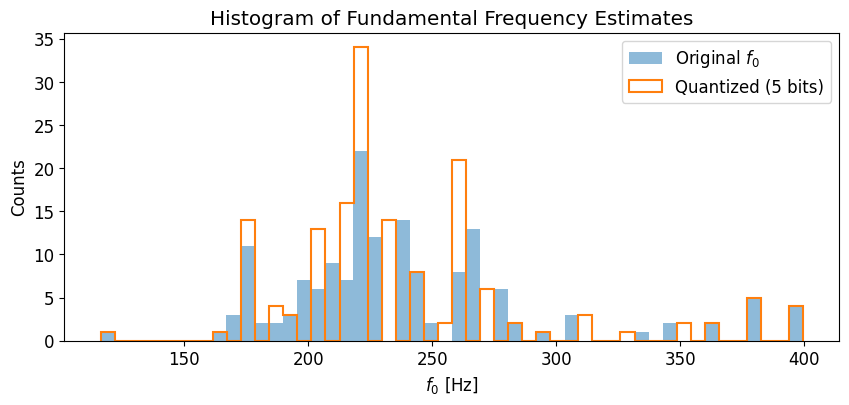

In [83]:
import numpy as np
import matplotlib.pyplot as plt

voiced_f0 = v_f0[v_voiced == 1]
voiced_f0 = voiced_f0[voiced_f0 > 0]  # Remove zero values

f0_min, f0_max = voiced_f0.min(), voiced_f0.max()
x_center_f0 = (f0_max + f0_min) / 2
x_range_f0 = (f0_max - f0_min) * 1.1  # Add 10% margin

print(f"F0 range: {f0_min:.1f} - {f0_max:.1f} Hz")
print(f"F0 center: {x_center_f0:.1f} Hz, range: {x_range_f0:.1f} Hz")

# Test different bit depths
for bits in [3, 4, 5, 6]:
    idxs_f0 = quantize_encoder(v_f0, bits, x_range_f0, x_center_f0)
    v_f0_q = quantize_decoder(idxs_f0, bits, x_range_f0, x_center_f0)
    
    # Synthesize with quantized f0
    synth_q = synthesize_speech_gain(v_voiced, v_f0_q, lpcs, v_power, fs, frame_length_ms, frame_shift_ms)
    
    print(f"\n{bits} bits for f0:")
    print(f"Playing synthesized signal with {bits}-bit quantized f0...")
    sd.play(synth_q, fs)
    sd.wait()

# Choose optimal bits (typically 4-5 bits work well)
bits_f0_optimal = 5
idxs_f0 = quantize_encoder(v_f0, bits_f0_optimal, x_range_f0, x_center_f0)
v_f0_q = quantize_decoder(idxs_f0, bits_f0_optimal, x_range_f0, x_center_f0)

plt.figure(figsize=(10,4))
plt.hist(v_f0[v_voiced == 1], bins=50, alpha=0.5, label='Original $f_0$')
plt.hist(v_f0_q[v_voiced == 1], bins=50, histtype='step', linewidth=1.5, label=f'Quantized ({bits_f0_optimal} bits)')
plt.title('Histogram of Fundamental Frequency Estimates')
plt.xlabel('$f_0$ [Hz]')
plt.ylabel('Counts')
plt.legend()
plt.show()



**Discussion:**
- $x\_range = f0\_max - f0\_min$, $x\_center = (f0\_max + f0\_min)/2$.
- Listening tests typically show **4–5 bits** suffice for $f_0$ without audible artifacts.
- The voiced/unvoiced flag is binary ⇒ **1 bit** (0=unvoiced, 1=voiced).

## 4.3 Quantizing the Signal Energy

**Tasks:**
1. Plot histogram of segment energies (linear scale) with 50 bins; choose `x_range` and `x_center`.
2. Find minimum bits for no perceptible distortion.
3. Repeat after taking $\log$ of energies; compare bits required.
4. Discuss linear vs logarithmic quantization and robustness to out‑of‑range signals.

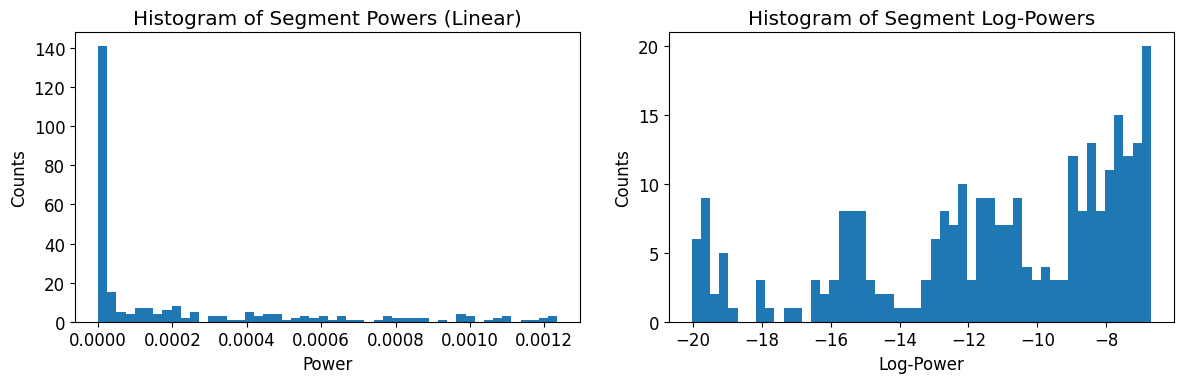

Linear power range: 0.000000 - 0.001235
Log power range: -20.04 - -6.70

3 bits - Linear quantization:
3 bits - Log quantization:


C:\Users\ayham\AppData\Local\Temp\ipykernel_16092\519438384.py:18: RuntimeWarning: invalid value encountered in sqrt
  gain = np.sqrt(v_power[i])



4 bits - Linear quantization:
4 bits - Log quantization:

5 bits - Linear quantization:
5 bits - Log quantization:

6 bits - Linear quantization:
6 bits - Log quantization:


In [76]:
# Linear scale histogram
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(v_power, bins=50)
plt.title('Histogram of Segment Powers (Linear)')
plt.xlabel('Power')
plt.ylabel('Counts')

# Log scale
log_energies = np.log(v_power + 1e-12)
plt.subplot(1,2,2)
plt.hist(log_energies, bins=50)
plt.title('Histogram of Segment Log-Powers')
plt.xlabel('Log-Power')
plt.ylabel('Counts')
plt.tight_layout()
plt.show()

# Linear quantization parameters
lin_min, lin_max = v_power.min(), v_power.max()
x_center_lin = (lin_max + lin_min)/2
x_range_lin = (lin_max - lin_min) * 1.1  # Add margin

# Log quantization parameters
log_min, log_max = log_energies.min(), log_energies.max()
x_center_log = (log_max + log_min)/2
x_range_log = (log_max - log_min) * 1.1  # Add margin

print(f"Linear power range: {lin_min:.6f} - {lin_max:.6f}")
print(f"Log power range: {log_min:.2f} - {log_max:.2f}")

# Test different bit depths for both linear and log
for bits in [3, 4, 5, 6]:
    # Linear quantization
    idxs_lin = quantize_encoder(v_power, bits, x_range_lin, x_center_lin)
    v_power_q_lin = quantize_decoder(idxs_lin, bits, x_range_lin, x_center_lin)
    
    # Log quantization
    idxs_log = quantize_encoder(log_energies, bits, x_range_log, x_center_log)
    v_power_q_log = np.exp(quantize_decoder(idxs_log, bits, x_range_log, x_center_log))
    
    # Synthesize with both
    synth_lin = synthesize_speech_gain(v_voiced, v_f0, lpcs, v_power_q_lin, fs, frame_length_ms, frame_shift_ms)
    synth_log = synthesize_speech_gain(v_voiced, v_f0, lpcs, v_power_q_log, fs, frame_length_ms, frame_shift_ms)
    
    print(f"\n{bits} bits - Linear quantization:")
    sd.play(synth_lin, fs)
    sd.wait()
    
    print(f"{bits} bits - Log quantization:")
    sd.play(synth_log, fs)
    sd.wait()

# Choose optimal (typically log with 4 bits)
bits_energy_optimal = 4
idxs_log = quantize_encoder(log_energies, bits_energy_optimal, x_range_log, x_center_log)
v_power_q = np.exp(quantize_decoder(idxs_log, bits_energy_optimal, x_range_log, x_center_log))


**Discussion:**
- **Logarithmic quantization** often needs fewer bits (3–4 bits) because energy distributions are skewed.
- Log‑domain quantization allocates more resolution to small values; linear may waste levels on rare extremes.
- If a new signal has much larger energy, linear will saturate; log‑domain or *adaptive range* solves this.

## 4.4 Quantizing the LPCs via Log‑Area Ratios

**Tasks:**
1. Convert LPCs → reflection coefficients → LAR:  
   `r = poly2rc(a)` → `lar = rc2lar(r)`.
2. Quantize `lar` with uniform quantizer; choose `x_range`, `x_center`, bits.
3. On decoding: `r_q = lar2rc(lar_q)`, `a_q = rc2poly(r_q)`.
4. Synthesize speech; compare spectrograms.

LAR range: -4.52 - 3.50
LAR matrix shape: (278, 10)

4 bits per LAR coefficient:

5 bits per LAR coefficient:

6 bits per LAR coefficient:

7 bits per LAR coefficient:


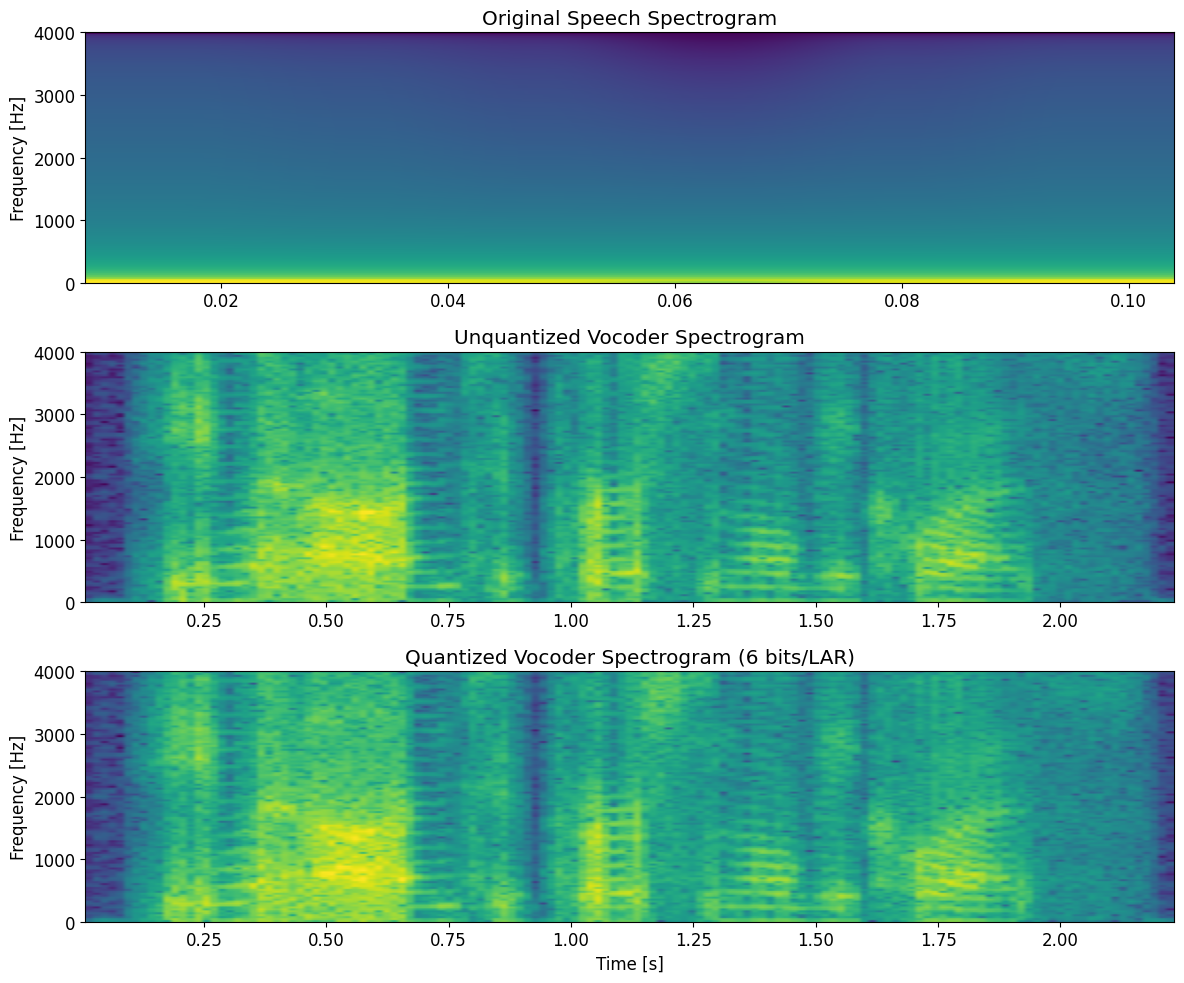

In [77]:
from lpctools import poly2rc, rc2lar, lar2rc, rc2poly
import numpy as np

# Convert LPCs to LAR for all frames
lar_matrix = np.zeros((m_lpc.shape[0], m_lpc.shape[1]))

for i in range(m_lpc.shape[0]):
    # Build full LPC polynomial [1, -a1, -a2, ...]
    lpc_poly = np.concatenate(([1], -m_lpc[i]))
    try:
        rc = poly2rc(lpc_poly)
        lar_matrix[i] = rc2lar(rc)
    except:
        # Handle unstable LPCs
        lar_matrix[i] = lar_matrix[i-1] if i > 0 else np.zeros(m_lpc.shape[1])

# Calculate quantization parameters
lar_min, lar_max = lar_matrix.min(), lar_matrix.max()
x_center_lar = (lar_max + lar_min)/2
x_range_lar = (lar_max - lar_min) * 1.1  # Add margin

print(f"LAR range: {lar_min:.2f} - {lar_max:.2f}")
print(f"LAR matrix shape: {lar_matrix.shape}")

# Test different bit depths
for bits_lar in [4, 5, 6, 7]:
    # Quantize LAR coefficients
    idxs_lar = quantize_encoder(lar_matrix.flatten(), bits_lar, x_range_lar, x_center_lar)
    lar_q = quantize_decoder(idxs_lar, bits_lar, x_range_lar, x_center_lar).reshape(lar_matrix.shape)
    
    # Convert back to LPCs
    lpcs_q = np.zeros_like(lpcs)
    for i in range(lar_q.shape[0]):
        try:
            rc_q = lar2rc(lar_q[i])
            lpc_poly_q = rc2poly(rc_q)
            lpcs_q[i] = lpc_poly_q
        except:
            lpcs_q[i] = lpcs[i]  # Use original if conversion fails
    
    # Synthesize with quantized LPCs
    synth_lpc_q = synthesize_speech_gain(v_voiced, v_f0, lpcs_q, v_power, fs, frame_length_ms, frame_shift_ms)
    
    print(f"\n{bits_lar} bits per LAR coefficient:")
    sd.play(synth_lpc_q, fs)
    sd.wait()

# Choose optimal bits (typically 5-6 bits)
bits_lar_optimal = 6
idxs_lar = quantize_encoder(lar_matrix.flatten(), bits_lar_optimal, x_range_lar, x_center_lar)
lar_q = quantize_decoder(idxs_lar, bits_lar_optimal, x_range_lar, x_center_lar).reshape(lar_matrix.shape)

# Convert back to quantized LPCs
lpcs_q = np.zeros_like(lpcs)
for i in range(lar_q.shape[0]):
    try:
        rc_q = lar2rc(lar_q[i])
        lpc_poly_q = rc2poly(rc_q)
        lpcs_q[i] = lpc_poly_q
    except:
        lpcs_q[i] = lpcs[i]

# Compare spectrograms
synth_original = synthesize_speech_gain(v_voiced, v_f0, lpcs, v_power, fs, frame_length_ms, frame_shift_ms)
synth_quantized = synthesize_speech_gain(v_voiced, v_f0, lpcs_q, v_power, fs, frame_length_ms, frame_shift_ms)

plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
plt.specgram(x, NFFT=256, Fs=fs, noverlap=128)
plt.title('Original Speech Spectrogram')
plt.ylabel('Frequency [Hz]')

plt.subplot(3, 1, 2)
plt.specgram(synth_original, NFFT=256, Fs=fs, noverlap=128)
plt.title('Unquantized Vocoder Spectrogram')
plt.ylabel('Frequency [Hz]')

plt.subplot(3, 1, 3)
plt.specgram(synth_quantized, NFFT=256, Fs=fs, noverlap=128)
plt.title(f'Quantized Vocoder Spectrogram ({bits_lar_optimal} bits/LAR)')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

plt.tight_layout()
plt.show()


**Discussion:**
- **Why LAR?** Quantizing LARs yields roughly constant sensitivity across the dynamic range and ensures stability (|r|<1) after reconstruction.
- Bits needed: **5–6 bits** per coefficient typically give transparent quality.
- Coarser quantization smooths formant peaks; slight blurring of spectral envelope at low bit-depths.

## 4.5 Data‑Rate Calculation

**Tasks:**
1. Count bits/frame for each parameter.
2. Frames per second = 1 / frame_shift.
3. Compute total bit-rate (kbit/s).
4. Compare to raw 16 bit/sample PCM.

In [78]:
frame_shift_sec = frame_shift_ms / 1000  # Convert to seconds
frames_per_sec = 1 / frame_shift_sec

# Actual parameter dimensions
M = m_lpc.shape[1]  # LPC order
bits_LPC = M * bits_lar_optimal  # bits per frame for LPCs
bits_f0 = bits_f0_optimal
bits_uv = 1  # voiced/unvoiced flag
bits_energy = bits_energy_optimal

# Calculate total bits per frame
bits_per_frame = bits_LPC + bits_f0 + bits_uv + bits_energy

# Calculate bit rates
bitrate_vocoder = bits_per_frame * frames_per_sec / 1000  # kbit/s
bitrate_pcm = 16 * fs / 1000  # kbit/s for 16-bit PCM

# Compression ratio
compression_ratio = bitrate_pcm / bitrate_vocoder

print("=== LPC Vocoder Bit Rate Analysis ===")
print(f"Frame rate: {frames_per_sec:.1f} frames/sec")
print(f"LPC order: {M}")
print(f"Bits per frame breakdown:")
print(f"  - LPCs: {bits_LPC} bits ({M} coeffs × {bits_lar_optimal} bits)")
print(f"  - F0: {bits_f0} bits")
print(f"  - V/UV: {bits_uv} bit")
print(f"  - Energy: {bits_energy} bits")
print(f"  - Total: {bits_per_frame} bits/frame")
print(f"\nBit rates:")
print(f"  - Vocoder: {bitrate_vocoder:.2f} kbit/s")
print(f"  - Raw PCM (16-bit): {bitrate_pcm:.1f} kbit/s")
print(f"  - Compression ratio: {compression_ratio:.1f}:1")
print(f"\nData reduction: {(1 - bitrate_vocoder/bitrate_pcm)*100:.1f}%")


=== LPC Vocoder Bit Rate Analysis ===
Frame rate: 125.0 frames/sec
LPC order: 10
Bits per frame breakdown:
  - LPCs: 60 bits (10 coeffs × 6 bits)
  - F0: 5 bits
  - V/UV: 1 bit
  - Energy: 4 bits
  - Total: 70 bits/frame

Bit rates:
  - Vocoder: 8.75 kbit/s
  - Raw PCM (16-bit): 128.0 kbit/s
  - Compression ratio: 14.6:1

Data reduction: 93.2%


**Discussion:**
- Typical LPC‑vocoder bit‑rates: **2–4 kbit/s**, versus **128 kbit/s** for 16‑bit/8 kHz PCM.
- Trade‑off: reduced rate → lower fidelity; suitable for low‑bandwidth links.